In [1]:
# model creation
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
# from scipy.stats import uniform
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

os.chdir('../data/')

data = pd.read_pickle('procesada/data_plus_census_added_features.pkl')
#data = data.query('state=="sp"').dropna()
data = data.dropna()

In [2]:
def model_metrics(model_search):
    print('Best parameters: {0}'.format(model_search.best_params_))
    print('Best score: {0:.3f}'.format(model_search.best_score_))
    print('Best model score in test: {0:.3f}'.format(accuracy_score(y_test, model_search.best_estimator_.predict(X_test))))
    print('Best model ROC in test: {0:.3f}'.format(roc_auc_score(y_test, model_search.best_estimator_.predict_proba(X_test)[:,1])))
    print('Confussion matrix in test:\n')
    print(pd.crosstab(y_test, model_search.best_estimator_.predict(X_test), normalize=True)*100)
    print('Classification report in test: \n')
    print(classification_report(y_test, model_search.best_estimator_.predict(X_test)))

In [3]:
features = data[[x for x in data.columns if data[x].dtype!='object']]
label = pd.to_numeric(data.final_decision=='A').astype(np.int8)

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

In [5]:
data.head()

,state,census_code,concat,final_decision,Cod_setor,Cod_UF,Cod_bairro,Cod_distrito,Cod_meso,Cod_micro,...,DOMICILIO_RENDA_V005_pct,DOMICILIO_RENDA_V006_pct,DOMICILIO_RENDA_V007_pct,DOMICILIO_RENDA_V008_pct,DOMICILIO_RENDA_V009_pct,DOMICILIO_RENDA_V010_pct,DOMICILIO_RENDA_V011_pct,DOMICILIO_RENDA_V012_pct,DOMICILIO_RENDA_V013_pct,DOMICILIO_RENDA_V014_pct
0,sp,353340305000020,"Ânielo Poconé , Lopes Iglesias , Nova Odessa , SP",A,353340305000020,SP,3533403012,353340305,3507,35032,...,0.000000,0.003268,0.032680,0.235294,0.434641,0.120915,0.084967,0.052288,0.006536,0.029412
1,sp,351960005000025,"Ângelo pacola n 610, Jardim pacola, Ibitinga ...",R,351960005000025,SP,3519600000,351960005,3505,35024,...,0.000000,0.021368,0.072650,0.329060,0.444444,0.076923,0.034188,0.012821,0.000000,0.008547
2,sp,350410705000009,"Área Rural, Área Rural de Atibaia, Atibaia, SP",R,350410705000009,SP,3504107013,350410705,3512,35048,...,0.000000,0.000000,0.085470,0.170940,0.256410,0.196581,0.179487,0.042735,0.034188,0.034188
3,sp,355030846000278,"vitorio, vila prel, sao paulo, SP",A,355030846000278,35,3550308000,355030846,3515,35061,...,0.000000,0.003788,0.106061,0.321970,0.306818,0.106061,0.071970,0.015152,0.000000,0.068182
4,sp,351040105000064,"vitorio roggieri , castelani, Capivari, SP",R,351040105000064,SP,3510401000,351040105,3506,35028,...,0.016575,0.031308,0.176796,0.445672,0.259669,0.036832,0.012891,0.005525,0.000000,0.014733


# Logistic regression

In [27]:
pipeline_logistic = Pipeline([('scaler', StandardScaler()), 
                              ('model', SGDClassifier(loss='log', penalty='elasticnet', random_state=2020, fit_intercept=True))],
                             verbose = False)

In [28]:
params_logistic = {'model__alpha': np.arange(0, 10, 0.2),
                   'model__l1_ratio': np.arange(0.01, 1, 0.02)}

model_logistic = RandomizedSearchCV(pipeline_logistic,
                                    params_logistic, 
                                    random_state=2020,
                                    scoring='accuracy',
                                    cv=5,
                                    n_iter=20,
                                    verbose=1,
                                    n_jobs=5)
model_logistic = model_logistic.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   11.6s finished


In [6]:
model_metrics(model_logistic)

Best parameters: {'model__l1_ratio': 0.15, 'model__alpha': 0.6000000000000001}
Best score: 0.686
Best model score in test: 0.681
Best model ROC in test: 0.773
Confussion matrix in test:

col_0                   0          1
final_decision                      
0               54.027149   3.725490
1               28.174962  14.072398
Classification report in test: 

              precision    recall  f1-score   support

           0       0.66      0.94      0.77      3829
           1       0.79      0.33      0.47      2801

    accuracy                           0.68      6630
   macro avg       0.72      0.63      0.62      6630
weighted avg       0.71      0.68      0.64      6630



# Random forest

In [29]:
rf_acceptance = RandomForestClassifier(n_estimators=50)
pipeline_rf = Pipeline([('scaler', StandardScaler()),
                        ('select_model', SelectFromModel(rf_acceptance, prefit=False)),
                        ('model', RandomForestClassifier(random_state=2020))],
                       verbose = False)

In [30]:
params_rf = {
    'model__n_estimators': [100, 200, 500],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 5, 10]
}

In [31]:
model_rf = RandomizedSearchCV(pipeline_rf, params_rf, cv=5, random_state=2020, n_iter=5, verbose=1, n_jobs=5)
model_rf = model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:  5.8min finished


In [32]:
model_metrics(model_rf)

Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10}
Best score: 0.731
Best model score in test: 0.733
Best model ROC in test: 0.798
Confussion matrix in test:

col_0                   0          1
final_decision                      
0               46.546003  11.206637
1               15.444947  26.802413
Classification report in test: 

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3829
           1       0.71      0.63      0.67      2801

    accuracy                           0.73      6630
   macro avg       0.73      0.72      0.72      6630
weighted avg       0.73      0.73      0.73      6630



# XGBoost

In [11]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params_xgb = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'max_depth': [3, 4, 5],
              'n_estimators': [100, 200, 300]
             }

xgb_instace = xgb.XGBClassifier(learning_rate=0.01,
                                objective='binary:logistic')

model_xgb = RandomizedSearchCV(xgb_instace, 
                               params_xgb, 
                               n_iter=15,
                               scoring='roc_auc',
                               n_jobs=5, 
                               cv=5, 
                               verbose=2,
                               random_state=2020)

model_xgb = model_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  6.0min
[Parallel(n_jobs=5)]: Done  75 out of  75 | elapsed: 12.5min finished


In [12]:
model_metrics(model_xgb)

Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.8}
Best score: 0.798
Best model score in test: 0.736
Best model ROC in test: 0.800
Confussion matrix in test:

col_0                   0          1
final_decision                      
0               46.500754  11.266968
1               15.098039  27.134238
Classification report in test: 

              precision    recall  f1-score   support

           0       0.75      0.80      0.78      3830
           1       0.71      0.64      0.67      2800

    accuracy                           0.74      6630
   macro avg       0.73      0.72      0.73      6630
weighted avg       0.73      0.74      0.73      6630



In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'eta': 0.01, 'objective': 'binary:logistic',
         'subsample': 0.8, 'min_child_weight': 1,
         'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.8}

# specify validations set to watch performance
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
watchlist = [(dtest, 'eval')]
num_round = 1400

bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=80, verbose_eval=False)

In [14]:
predictions = (bst.predict(dtest)>0.5).astype(np.int8)
accuracy_score(y_test, predictions)

0.7392156862745098

# Comparing ROC curves

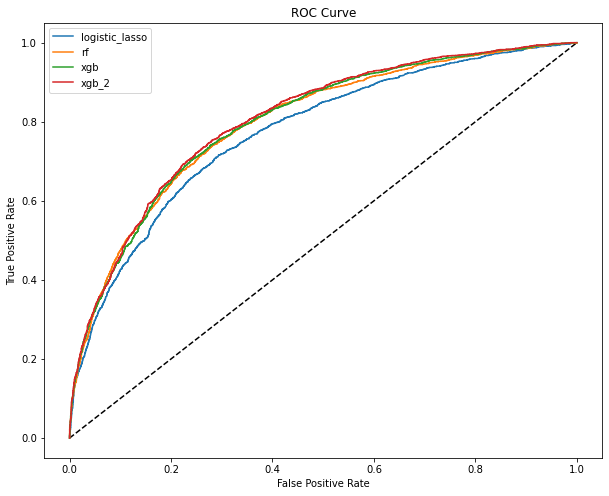

In [15]:
names_models = ['logistic_lasso', 'rf', 'xgb']
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([0, 1], [0, 1], 'k--')
for idx, model_i in enumerate([model_logistic, model_rf, model_xgb]):
    fpr, tpr, thresholds = roc_curve(y_test, model_i.best_estimator_.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=names_models[idx])

fpr, tpr, thresholds = roc_curve(y_test, bst.predict(dtest))
plt.plot(fpr, tpr, label='xgb_2')
ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()